# Rechorder

## Automatic sheet music composition

Import libraries:
pip install numpy pyaudio scipy music21

In [1]:
from datetime import date
import struct
import numpy as np
from scipy.fftpack import fft
import pyaudio
import music21 # install musescore
from music21 import environment
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/musescore'

### Functions

In [2]:
def input_stream(key, hz, notes):
    note = scale[(key - 1) % 12] + str((key+8) // 12) # note as string
    print(note, '\t', int(hz))

    return note

In [3]:
def display(music):
    s = music21.stream.Score()
    s.insert(0, music21.metadata.Metadata())
    s.metadata.title = "title"
    day = date.today()
    s.metadata.date = f"{day.year}/{day.month}/{day.day}"
    s.metadata.composer = "composer"
    
    for n in music:
        if n[0] == 'R':
            s.append(music21.stream.note.Rest(n[n.index('-')+1:]))
        else:
            s.append(music21.note.Note(n[:n.index('-')], type=types[n[n.index('-')+1:]]))
    
    try:
        s.show()
    except:
        s.show("text")
    return None

Transpose notes to sheet music using music21

In [4]:
def transcribe(notes):
    music = []
    nps = 12 # in 1 second, the program records 12 notes
    i = 0
    j = 1
    
    while i < len(notes): # optimize loop
        try:
            if notes[i] == notes[j]:
                j += 1
            else:
                dur = str(min([1,2,4,8,16,32], key=lambda x:abs(x-(round(1 / (j - i) * nps)))))
                music.append(notes[i] + '-' + dur)
                i = j
                j += 1 # slightly faster
        except IndexError:
            dur = str(min([1,2,4,8,16,32,64], key=lambda x:abs(x-(round(1 / (j - i) * nps))))) # can this cause div 0 error?
            music.append(notes[i] + '-' + dur)
            i = j + 1
    
    display(music)
    return None

Convert frequencies to keys

In [5]:
def conv(fs):
    fs_max = -np.sort(-fs)

    key = None
    i = 0
    while not key:
        i += 1
        hz = round((np.where(fs == fs_max[i])[0][0]) * RATE / CHUNK) # convert FFT to hz
        note = int(round(12 * np.log2(hz/440) + 49)) # hz to note on piano
        if note > 0 and note < 109:
            key = note

    return key, hz

Audio input stream function

In [6]:
def record(rests = True):
    # stream object
    p = pyaudio.PyAudio()
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        output=True,
        frames_per_buffer=CHUNK,
    )
    
    print("\nstarted recording...\n")
    notes = ['R']
    try:
        while True:
            data = stream.read(CHUNK, exception_on_overflow=False)
            data_int = struct.unpack(str(2 * CHUNK) + 'B', data)
            data_np = np.array(data_int, dtype='b')[::2] + 128
            if np.percentile(np.abs(data_np), 90) >= 200: # check volume if a note is being played
                # compute FFT and update line
                fs = np.abs(fft(data_int)[0:CHUNK])
                key, hz = conv(fs) # convert most common frequencies
                notes.append(input_stream(key, hz, notes))
            elif rests and len(notes) > 1:
                notes.append('R')

    except KeyboardInterrupt:
        p.close(stream)
        print("\n\nended recording\n")

    return notes

Define variable constants

In [7]:
# stream constants
CHUNK = 1024 * 2
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 22050

scale = ['A', "A#", 'B', 'C', "C#", 'D', "D#", 'E', 'F', "F#", 'G', "G#"]
types = {'1': "whole", '2': "half", '4': "quarter", '8': "eighth", '16': "sixteenth"}

### Conversion program

Record audio and transcribe frequencies to sheet music

In [8]:
notes = record(rests=False) # interrupt to end stream


started recording...

C#3 	 140
G2 	 97
A#2 	 118
C#3 	 140


ended recording



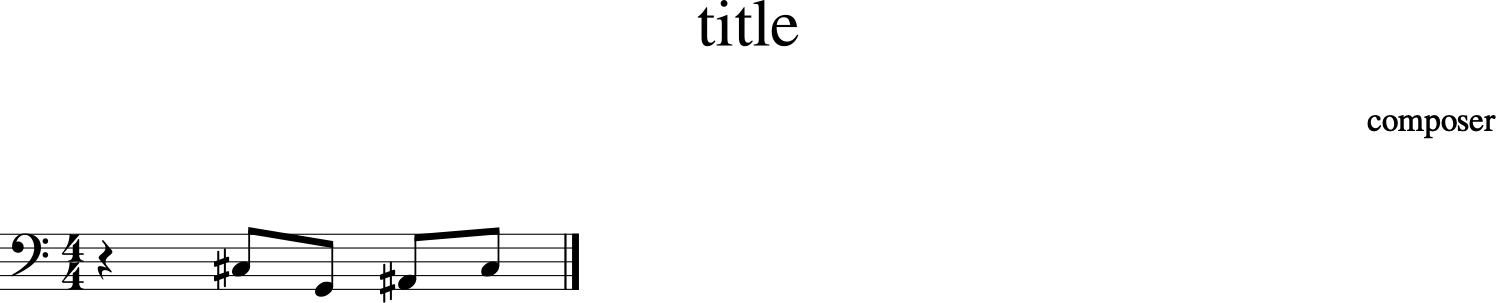

In [9]:
transcribe(notes)